# Orbit response

In [1]:
import sys
import os
from os.path import join
from collections import Counter
from datetime import datetime
import h5py
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt
import proplot as pplt

sys.path.append('/Users/46h/Research/code/optimized_sav_gal/')
import sgfilter

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'

In [2]:
def get_quad_id(filename):
    return filename.split('_')[5]

def get_quad_number(filename):
    return int(get_quad_id(filename)[2:])

def mean_std(x, f):
    N = np.sum(f)
    mean = np.sum(f * x) / N
    std = np.sum(f * (x - mean)**2) / N
    return mean, std

def autofilter(signal):
    n_opt = sgfilter.n_opt(signal)
    signal_filtered = sgfilter.sg_filter_gram(signal, n_opt, 2)
    return signal_filtered.values

In [3]:
folder = 'Diagnostics/Data/Measurements/2022-04-25/'
filenames = os.listdir(folder)
filenames = [filename for filename in filenames if 'orbit_response' in filename]
filenames = sorted(filenames, key=get_quad_number, reverse=True)
filenames

['220425114421-orbit_response_2d-response_HZ04_HZ06_QH13_Cam09.h5',
 '220425120001-orbit_response_2d-response_HZ04_HZ06_QV12_Cam09.h5',
 '220425121535-orbit_response_2d-response_HZ04_HZ06_QH11_Cam09.h5',
 '220425123108-orbit_response_2d-response_HZ04_HZ06_QV10_Cam09.h5',
 '220425124641-orbit_response_2d-response_HZ04_HZ06_QV09_Cam09.h5',
 '220425130350-orbit_response_2d-response_HZ04_HZ06_QH08_Cam09.h5',
 '220425131929-orbit_response_2d-response_HZ04_HZ06_QV07_Cam09.h5']

## Explore one file 

In [4]:
filename = filenames[0]
file = h5py.File(join(folder, filename), 'r')
list(file.keys())

['config', 'log', 'scandata']

In [8]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

environment
--------------
timestamp: [1.65090146e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'misc/orbit_response_2d.py']
work_dir: [b'/home/46h/se-template']

metadata
--------------
timestamp: [1.65090147e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [5.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55000019]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.0999999]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.30000019]
BTF_MEBT_Mag:PS_DCH01:I_Set: [4.7]
BTF_MEBT_Mag:PS_DCV01:I_Set: [-3.]
BTF_MEBT_Mag:PS_DCH02:I_Set: [5.]
BTF_MEBT_Mag:PS_DCV02:I_Set: [-2.]


In [9]:
data = file['scandata']
print('Data:')
for i, name in enumerate(data.dtype.names):
    print(f'{name} [{data.dtype[i]}]')
print()

slits = [key for key in data.dtype.names if 'PositionSync' in key]
print(f'slits: {slits}')

Data:
timestamp [float64]
iteration [int64]
Cam09_ProfileY [('<f4', (512,))]
Cam09_ProfileX [('<f4', (612,))]
HZ04_PositionSync [float64]
HZ06_PositionSync [float64]
QH13_CurrentRb [float64]
QH13_CurrentSet [float64]

slits: ['HZ04_PositionSync', 'HZ06_PositionSync']


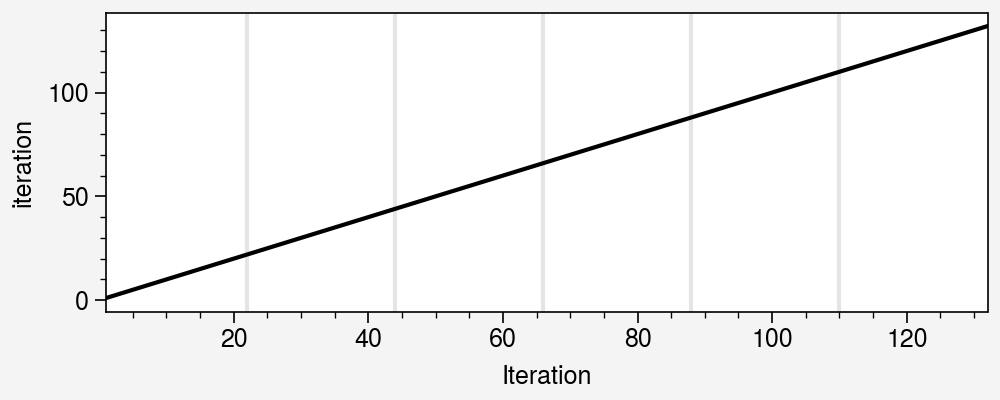

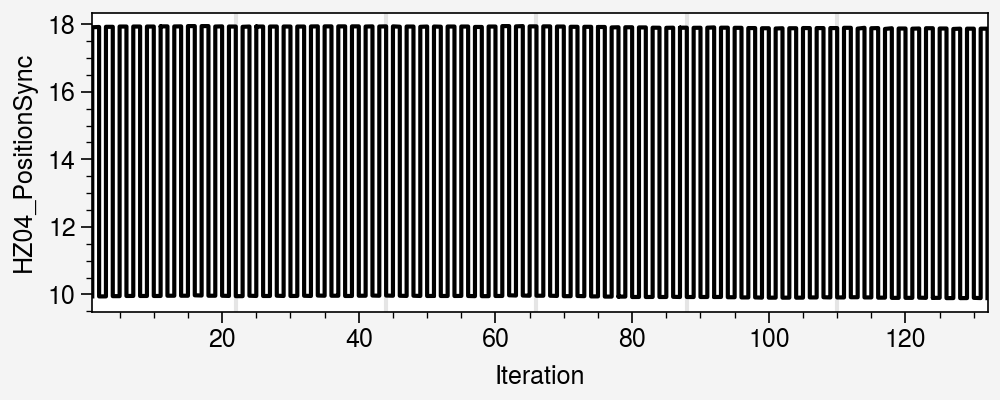

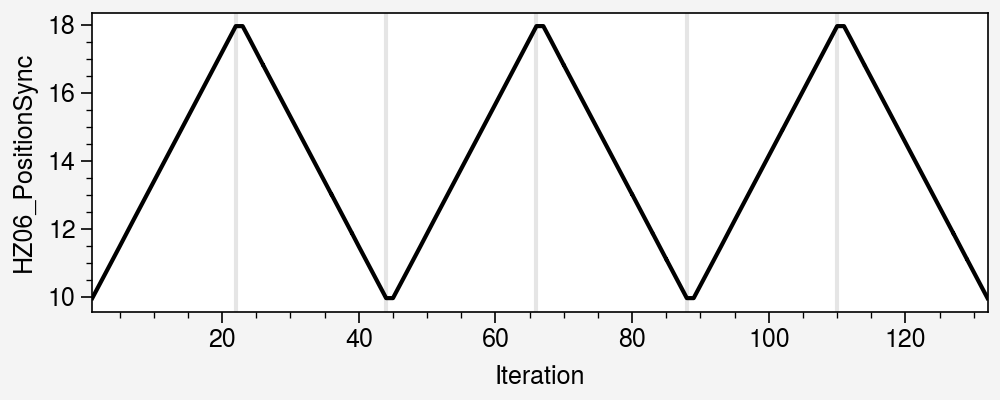

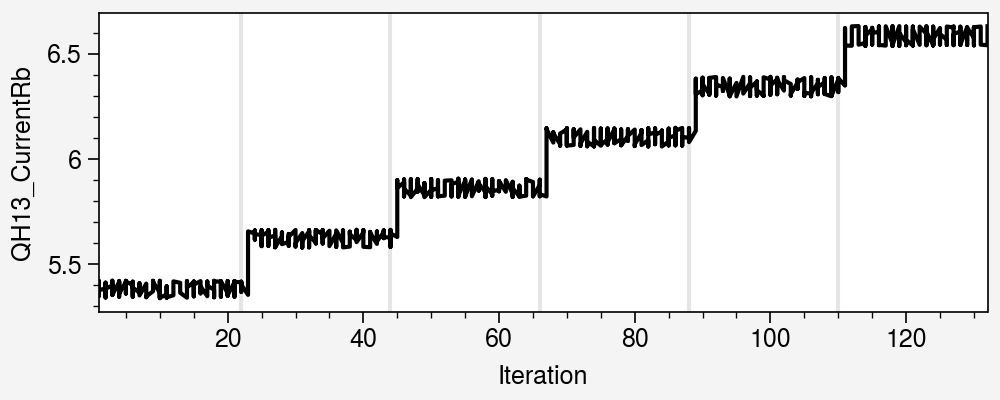

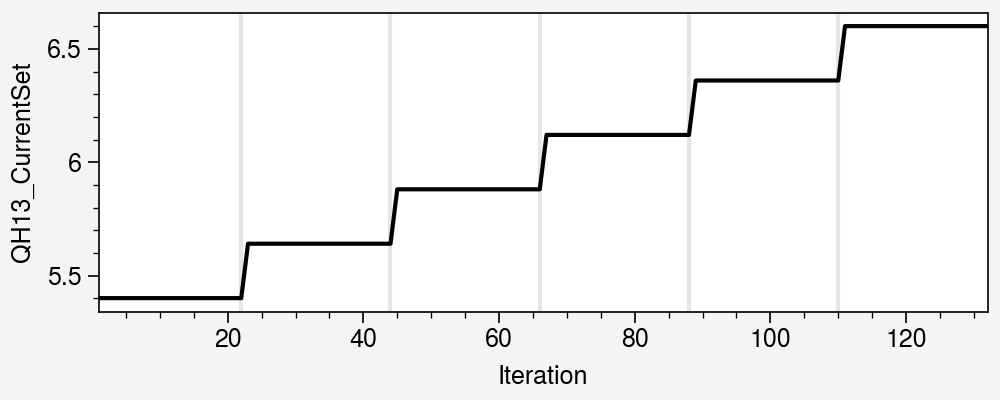

In [21]:
for name in data.dtype.names:
    if name in ['timestamp', 'Cam09_ProfileX', 'Cam09_ProfileY']:
        continue
    fig, ax = pplt.subplots(figsize=(5.0, 2.0))
    ax.plot(data['iteration'], data[name], color='black')
    for i in [22, 44, 66, 88, 110]:
        ax.axvline(i, color='black', alpha=0.1)
    ax.format(xlabel='Iteration', ylabel=name)
    plt.show()

One iteration = one sweep of the first slit. One iteration should be equal to 22 steps. I will let one "period" = one sweep of the second slit. One period should be equal to 22 iterations. The quad current is changed after each period.

Let's get the step indices for each period.

In [11]:
quad_id = get_quad_id(filename)
period_length = 22
idx_dict = dict()
for period in range(1, 7):
    idx = np.logical_and(
        data['iteration'] >= (period - 1) * period_length + 1,
        data['iteration'] <= period * period_length,
    )
    idx_dict[period] = data['iteration'][idx]
idx_dict

{1: array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         

Recall that our goal is to compute the beam centroid for each x,x' as a function of quad current. First, let's get the data from this period.

In [13]:
period = 1
idx = idx_dict[period]
slit_pos = {slit: data[slit] for slit in slits}
quad_current_avg = np.mean(data[f'{quad_id}_CurrentRb'][idx])
xprofiles = data['Cam09_ProfileX'][idx, :]
yprofiles = data['Cam09_ProfileY'][idx, :]
print(f'quad_current_avg = {quad_current_avg:.2f}')

quad_current_avg = 5.39


For some reason, there are more than 22 steps (positions of the sweeping slit) per iteration. Furthermore, the number of steps per iteration changes on each iteration. I'm not sure why.

In [14]:
steps_per_iter = Counter(idx)
print('Iteration: number of steps')
steps_per_iter

Iteration: number of steps


Counter({1: 29,
         2: 29,
         3: 30,
         4: 29,
         5: 29,
         6: 29,
         7: 29,
         8: 29,
         9: 29,
         10: 29,
         11: 29,
         12: 29,
         13: 28,
         14: 29,
         15: 29,
         16: 28,
         17: 29,
         18: 29,
         19: 28,
         20: 28,
         21: 29,
         22: 29})

We could cut them off at the same number; hold off for now.

Let's look at the profiles at the first iteration — as the first slit sweeps.

In [19]:
iteration = 1
steps = steps_per_iter[iteration]
lo = iteration - 1
hi = lo + steps
_yprofiles = yprofiles[lo:hi, :]

for i, y in enumerate(_yprofiles):
    x = 0.023 * np.arange(len(y))  # 0.024 mm/pixel at zoom=1.0.
    y_filtered = autofilter(y)
    imean = np.argmax(y_filtered)
    mean = x[imean]
    print(f'mean = {mean:.2f}')
#     fig, ax = pplt.subplots()
#     ax.plot(x, y, color='black', alpha=0.1, label='original')
#     ax.plot(x, y_filtered, color='black', label='filtered')
#     ax.format(yticklabels=[], ylabel='Amplitude', xlabel='y [mm]')
#     ax.axvline(mean, color='pink8', alpha=0.5, label='mean')
#     ax.legend(loc='top', framealpha=0.0)
# #     plt.savefig(f'_output/Cam09_ProfileY_{i}')
#     plt.show()

mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61
mean = 7.61


I want to know: for a given x and x', how does it's position on the screen change as a function of quad strength? That means that I need to match up iterations between periods.

In [ ]:
d